# Investigating Implied Volatiliy for BSM Models

In [1]:
import numpy as np 
from scipy.stats import stats
from scipy.stats.distributions import norm 
from scipy.optimize import newton
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Black Scholes Merton Model

In [2]:
def black_scholes_call(S_0, K, T, r, sigma):
    d1 = (np.log(S_0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    call = S_0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return call


## Finding the Implied Volatilty Parameter

In [3]:
def implied_volatility(C, S, K, r, T, sigma_init=0.2):
    """
    Calculate implied volatility using Newton-Raphson method.
    
    Parameters:
    C (float): Market price of call option
    S (float): Current stock price
    K (float): Strike price
    r (float): Risk-free interest rate
    T (float): Time to expiration (in years)
    sigma_init (float): Initial volatility guess
    
    Returns:
    float: Implied volatility
    """
    def objective(sigma):
        return (black_scholes_call(S, K, r, sigma, T) - C)**2
    
    implied_vol = newton(objective, sigma_init)
    return implied_vol

## Visualization Demo of one-to-one Mapping with BSM & Implied Vol. 

Essentially, what we we want to accomplish is exactly the same as a bijective functions such as f(x) = 2x. 2 -> 4, and for f^-1, 4 -> 2. No other values for all real numbers give 4 or two respectively in our range. 

Using the same thought process, 
S (spot price) 
K (strike price)
r (risk-free interest rate)
sigma (volatility)
T (time-to-exercise)

(S,K,r,sigma,T) -> f (option price)
Essentially, we can look at this as a function of only volatily since the rest of these parameters are determined by the market. 
BS(sigma) -> f and move this to BS^-1(f) = sigma. 

Minimizing over all possible option prices using the newton-raphson method, we get our implied volatility. 


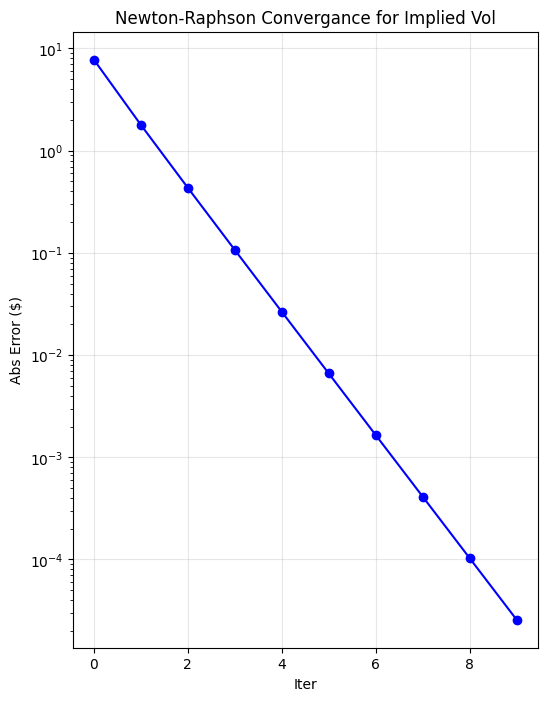

In [4]:
def plot_convergance(C, S, K, T, r, sigma_init=0.2): 
    def objective(sigma):
        return (black_scholes_call(S, K, r, sigma, T) - C)**2
    
    def derivative(sigma):
        h = 1e-7
        return (objective(sigma + h) - objective(sigma)) / h
    sigmas=[]
    errors=[]
    sigma=sigma_init
    for i in range(10):
        sigmas.append(sigma)
        error = abs(objective(sigma))
        errors.append(error)

        if error < 1e-10: 
            break
        sigma = sigma - objective(sigma)/derivative(sigma)

    plt.figure(figsize=(6,8))
    plt.semilogy(range(len(errors)), errors, 'bo-')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Iter')
    plt.ylabel('Abs Error ($)')
    plt.title('Newton-Raphson Convergance for Implied Vol')

    plt.show()

plot_convergance(C=12.15, S=100, K=100, r=0.05, T=1)

In [5]:

# Data for the volatility surface
strikes = [90, 95, 100, 105, 110]
maturities = [1/12, 3/12, 6/12, 1, 2]  # in years
maturity_labels = ['1 Month', '3 Months', '6 Months', '1 Year', '2 Years']

# Volatility values (in %)
vols = np.array([
    [28.0, 24.5, 22.0, 20.5, 19.5],  # 1 month
    [27.5, 24.0, 21.8, 20.3, 19.3],  # 3 months
    [27.0, 23.5, 21.5, 20.0, 19.0],  # 6 months
    [26.5, 23.0, 21.2, 19.8, 18.8],  # 1 year
    [26.0, 22.5, 21.0, 19.5, 18.5]   # 2 years
])

# Create meshgrid for 3D surface
X, Y = np.meshgrid(strikes, maturities)

# Create the 3D surface plot
fig = go.Figure(data=[go.Surface(
    x=X,
    y=Y,
    z=vols,
    colorscale='viridis'
)])

# Update layout
fig.update_layout(
    title='Implied Volatility Surface',
    scene=dict(
        xaxis_title='Strike Price',
        yaxis_title='Time to Maturity (Years)',
        zaxis_title='Implied Volatility (%)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.2)
        )
    ),
    width=800,
    height=600,
    template='plotly_dark',
    paper_bgcolor='rgb(30,30,30)',
    plot_bgcolor='rgb(30,30,30)'
)

# Show the plot
fig.show()